In [3]:
%cd /Users/rattie/Dev/sdo_tracking_framework
import os, glob
import time
import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import fitstools
import fitsio
import balltracking.balltrack as blt
from astropy.io import fits

/Users/rattie/Dev/sdo_tracking_framework


In [4]:
def balltrack_calibration(datafiles, fwhm, fov_slices, reprocess_bt, use_existing, outputdir):

    # Select only a subset of nframes files
    selected_files = datafiles[0:nframes]
    # Load the nt images
    images = fitstools.fitsread(selected_files)
    
    start_time_clock = time.clock()
    if reprocess_bt:
         # Must make even dimensions for the fast fourier transform
        images2 = np.zeros([264, 264, images.shape[2]])
        images2[0:263, 0:263, :] = images.copy()
        images2[263, :] = images.mean()
        images2[:, 263] = images.mean() 
        
        cal = blt.Calibrator(images2, drift_rates, nframes, rs, dp, sigma_factor, outputdir,
                             intsteps=intsteps,
                             output_prep_data=False, use_existing=use_existing,
                             nthreads=5)

        ballpos_top_list, ballpos_bottom_list = cal.balltrack_all_rates()
    else:
        print('Load existing tracked data at all rates')
        ballpos_top_list = np.load(os.path.join(outputdir, 'ballpos_top_list.npy'))
        ballpos_bottom_list = np.load(os.path.join(outputdir, 'ballpos_bottom_list.npy'))
    
    duration_time_clock = time.clock() - start_time_clock 
    print('duration_time_clock:   ', duration_time_clock)
    
    trange = [0, nframes]
    xrates = np.array(drift_rates)[:, 0]
    a_top, vxfit_top, vxmeans_top, residuals_top = blt.fit_calibration(ballpos_top_list, xrates, trange, fwhm,
                                                        images.shape[0:2], fov_slices,
                                                        return_flow_maps=False)
    a_bottom, vxfit_bottom, vxmeans_bottom, residuals_bottom = blt.fit_calibration(ballpos_bottom_list, xrates, trange, fwhm,
                                                                 images.shape[0:2], fov_slices,
                                                                 return_flow_maps=False)

    return a_top, vxfit_top, vxmeans_top, residuals_top, a_bottom, vxfit_bottom, vxmeans_bottom, residuals_bottom


def average_calibration(vxfit_top, vxfit_bottom, vx_rates):
    # Fit the averaged calibrated balltrack velocity
    vxmeans_bt = (vxfit_top + vxfit_bottom)/2
    # #vxmeans_bt -= vxmeans_bt[4]
    p = np.polyfit(vx_rates, vxmeans_bt, 1)
    a_avg = 1 / p[0]
    vxfit_avg = a_avg * (vxmeans_bt - p[1])
    # # Calculate residuals
    bt_residuals = np.abs(vxmeans_bt - vx_rates)
    #bt_residuals_fit = np.abs(vxfit_avg - vx_rates)
    print('a_avg = {:0.2f}, p[1] = {:0.2f}'.format(a_avg, p[1]))
    return vxmeans_bt, a_avg, vxfit_avg, bt_residuals



def dv_analysis(vx_files, vx_ratesu, fov_slices):
    # Benoit's data are already in physical units (m/s). The drift rates must also be in that unit.
    vxmeans = []
    for i in range(len(vx_files)):
        vx = fitsio.read(vx_files[i])
        vxmeans.append(vx[fov_slices[1], fov_slices[0]].mean())
    vxmeans = np.array(vxmeans)# - vxmeans[4]
    ## Calibration parameters: y_measured = p0*x_true + p1 => true = (measured - p1)*1/p0
    p = np.polyfit(vx_ratesu, vxmeans, 1)
    a_v = 1 / p[0]
    vxfits = a_v * (vxmeans - p[1])
    # Calculate residuals
    residuals0 = np.abs(vxmeans - vx_ratesu)
    residuals = np.abs(vxfits - vx_ratesu)

    return vxmeans, a_v, vxfits, residuals0, residuals


In [88]:
# input data, list of files
# glob.glob does not order numbered files by defaultl, the order is as appeared in the file system.
datafiles = sorted(glob.glob('/Users/rattie/Data/Ben/SteinSDO/SDO_int*.fits'))
# directory of the drifting images for Balltracking. 
driftdir = '/Users/rattie/Data/Ben/SteinSDO/calibration2/unfiltered'
# output directory for the plots
plotdir = '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/'
# Set if we balltrack again or use previous results
reprocess_bt = False
# Set if we use existing drifted images
use_existing = True
    
nframes = 80
# Ball radius
rs = 2
# depth factor
dp = 0.3
# Nb of integration steps between images
intsteps = 5
# Multiplier to the standard deviation.
sigma_factor = 1

fwhm = 7
dv = 0.02
vx_rates = np.arange(-0.2, 0.2+0.9*dv, dv)
vx_rates[int(len(vx_rates)/2)] = 0
ndrifts = len(vx_rates)
# The drift can optionnally be on both direction, not just on the x-axis
drift_rates = np.stack((vx_rates, np.zeros(ndrifts)), axis=1).tolist()
# Select a subfield excluding edge effects
imsize = 263 # actual size is 264 but original size was 263 then padded to 264 to make it even for the Fourier transform
trim = int(vx_rates.max() * nframes + fwhm + 2)
fov_slices = np.s_[trim:imsize - trim, trim:imsize-trim]

unit = 368000 / 60 # m/s
unit_str = '[m/s]'
vx_ratesu = vx_rates * unit
bar_labels = ['{:0.0f}'.format(vxrate) for vxrate in vx_ratesu]

## Balltracking

In [89]:
    # Select a subfield excluding edge effects
    fov_slices_bt = [fov_slices, ]
    ##########################################
    ######  Smoothing at FWHM = 7 px #########
    fwhm = 7
    a_top1, vxfit_top1, vxmeans_top1, res_top1, a_bot1, vxfit_bot1, vxmeans_bot1, res_bot1 = balltrack_calibration(datafiles, fwhm, fov_slices_bt, reprocess_bt, use_existing)
    vxmeans_bt1, a_avg1, vxfit_avg1, bt_residuals1 = average_calibration(vxfit_top1, vxfit_bot1, vx_rates)

Load existing tracked data at all rates
duration_time_clock:    0.3308969999999931
a_avg = 1.00, p[1] = 0.00


## Load Benoit's FLCT results 

In [19]:
# Benoit FLCT data directory. 1 directory per drift value -> 9 directories for 9 drift values
data_dir = '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7'
fvx_files = [os.path.join(data_dir, 'drift_filt_non_norm_{:02d}'.format(i), 'FLCT_vx1_000-079.fits') for i in range(ndrifts)]
fvx_files

['/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/drift_filt_non_norm_00/FLCT_vx1_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/drift_filt_non_norm_01/FLCT_vx1_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/drift_filt_non_norm_02/FLCT_vx1_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/drift_filt_non_norm_03/FLCT_vx1_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/drift_filt_non_norm_04/FLCT_vx1_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/drift_filt_non_norm_05/FLCT_vx1_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_Benoit/output_flct_sigma7/drift_filt_non_norm_06/FLCT_vx1_000-079.fits',
 '/Users/rattie/Data/Ben/SteinSDO/calibration2/filtered/FLCT_B

In [20]:
# Loop through Benoit's matrix data
fvxmeans, a_fv, fvxfits, fv_residuals0, fv_residuals = dv_analysis(fvx_files, vx_ratesu, fov_slices)

In [66]:
# Setup some figure parameters
label = 'FLCT'
# Default plot params
fs = 12
plt.rcParams.update({'font.size': fs})
markers = 'd'
colors = 'red'
legend_loc = 'lower right'
# Widths of bar plots
widths = [0.015, 0.015, 0.01]
# Plot figure file name suffix
fig_suffix = 'intsteps_{:d}_dp_{:0.2f}_sigma_factor_{:0.2f}'.format(intsteps, dp, sigma_factor)
dpi = 300

<IPython.core.display.Javascript object>


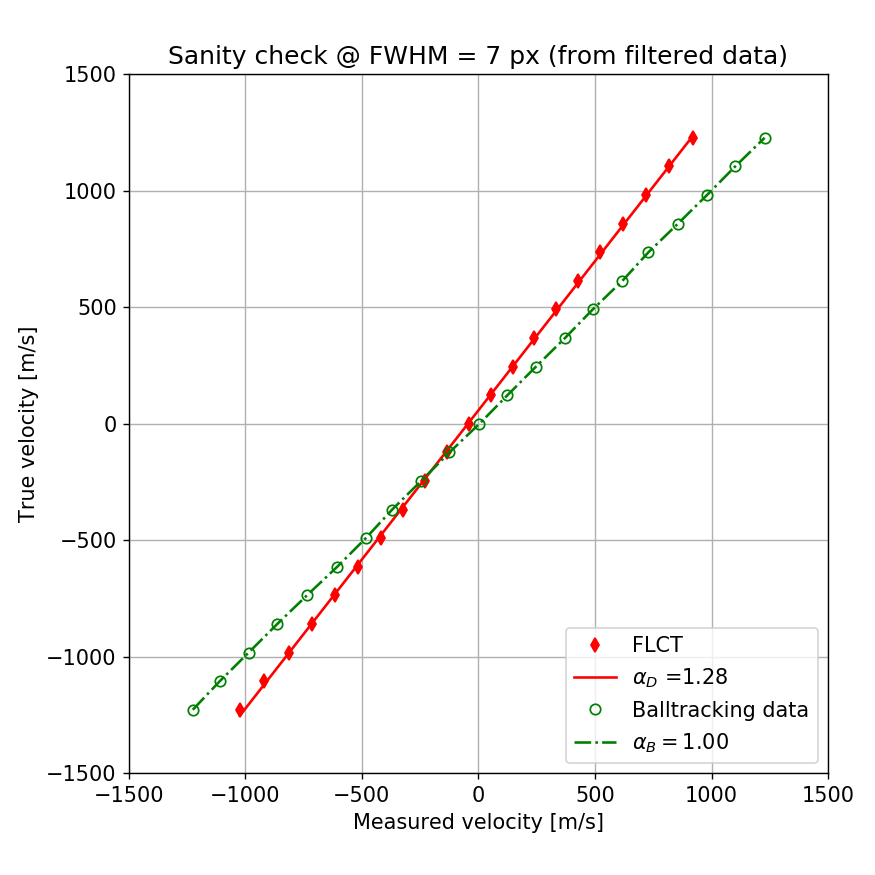

In [86]:
    maxv = 1500

    %matplotlib notebook
    fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(7, 7))
    axs.set_title('Sanity check @ FWHM = 7 px (from filtered data)')
    # Consider only the unfiltered ones (the filtered ones do not work). range from 0 to 5 incl.
    axs.plot(fvxmeans, vx_ratesu, marker=markers, color=colors, ls='none', label=label)
    axs.plot(fvxmeans, fvxfits, color=colors, label=r'$\alpha_{:s}$ ={:0.2f}'.format('D', a_fv))

    axs.plot(vxmeans_bt1 * unit, vx_ratesu, marker='o', markerfacecolor='none', ls='none', color='green', label='Balltracking data')
    axs.plot(vxfit_avg1 * unit, vx_ratesu, ls='-.', color='green', label=r'$\alpha_B = {:0.2f}$'.format(a_avg1))

    axs.axis([-maxv, maxv, -maxv, maxv])
    axs.set_xlabel('Measured velocity {:s}'.format(unit_str), fontsize=fs)
    axs.set_ylabel('True velocity {:s}'.format(unit_str), fontsize=fs)
    axs.legend(loc=legend_loc)
    axs.grid(True)
    axs.set_aspect('equal')

    plt.tight_layout()

### Show uncorrected and corrected residuals

<IPython.core.display.Javascript object>


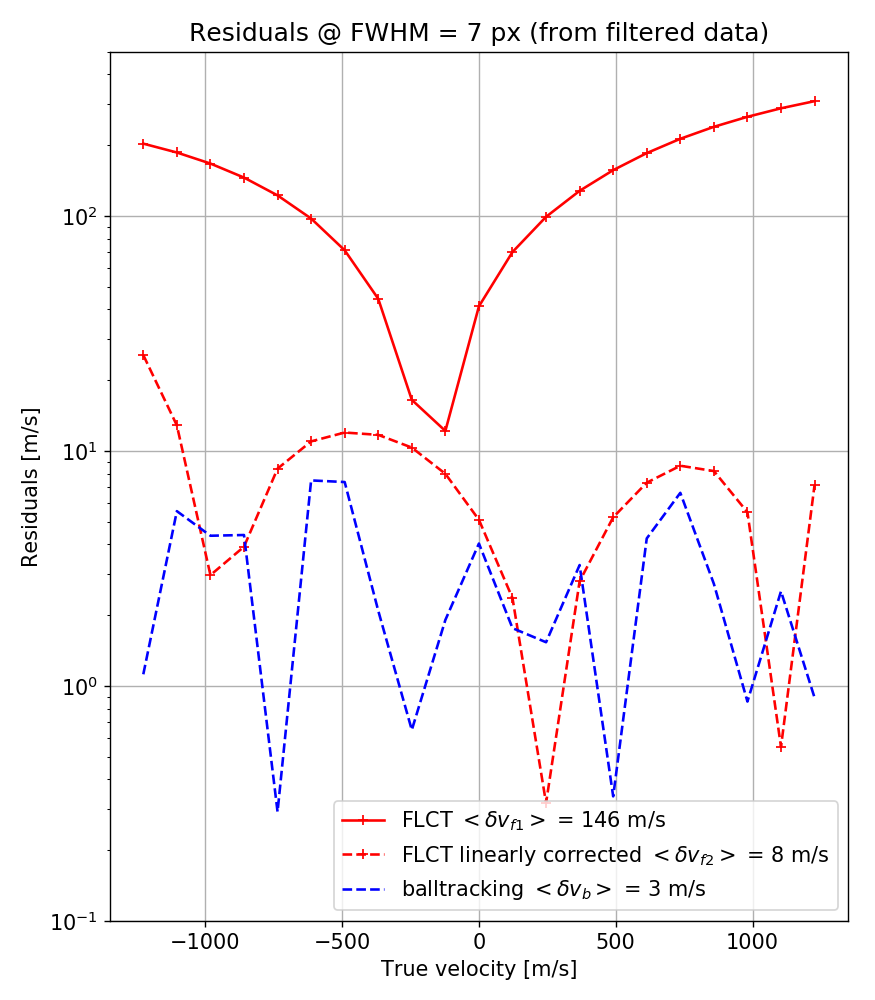

In [87]:
######################################
##### Residuals with linear correction
######################################
bt_residuals1u = bt_residuals1 * unit

max_resid1 = 500#0.1 * unit

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(7, 8))
axs.set_title('Residuals @ FWHM = 7 px (from filtered data)')
axs.set_xlabel('True velocity {:s}'.format(unit_str))
axs.set_ylabel('Residuals {:s}'.format(unit_str))
bar_labels = ['{:0.0f}'.format(vxrate) for vxrate in vx_ratesu]

width = widths[0]*0.7 * unit
axs.plot(vx_ratesu, fv_residuals0, 'r-', marker='+', label=r'FLCT $<\delta v_{{f1}}>$ = {:.0f} m/s'.format(fv_residuals0.mean()))
axs.plot(vx_ratesu, fv_residuals, 'r--', marker='+', label=r'FLCT linearly corrected $<\delta v_{{f2}}>$ = {:.0f} m/s'.format(fv_residuals.mean()))
axs.plot(vx_ratesu, bt_residuals1u, 'b--', label=r'balltracking $<\delta v_b>$ = {:.0f} m/s'.format(bt_residuals1u.mean()))
#axs[0].bar(vx_ratesu, bt_residuals1 * unit, width=widths[0]*0.7 * unit, color='green', tick_label=None, label='balltracking')
axs.set_yscale('log')
axs.set_ylim([0.1, max_resid1])
axs.legend()
axs.grid(True)


plt.tight_layout()

#plt.savefig(os.path.join(outputdir, 'Benoit_FLCT_residuals_{:s}.png'.format(fig_suffix)), dpi=dpi)